Almost all the error comes from the CNOT gates. Lets investigate whether this varies with beta

## Hardware

In [52]:
run_on_hardware = False

### Set up server

In [53]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import Parameter

# details to allow it to run later
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")

# Make the circuit
# Can initialise it all now and pass in a parameter 
def make_circuit(gamma):
    qc = QuantumCircuit(2)
    # gamma = Parameter("angle")
    # some hadamard gates first to ensure entanglement
    qc.h(0)
    qc.h(1)
    qc.rzz(2 * gamma, 0, 1)  # Virtual Rz(2γ)
    qc.metadata = {"gamma": gamma}  # Store gamma value
    qc.measure_all()
    return qc

### submit to run on ibm hardware

In [54]:
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
# pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)
from qiskit_ibm_runtime import Batch
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
backend = service.backend("ibm_brisbane")
pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Define rotation angles to test
gamma_values = np.pi*np.linspace(0, 1, 20)  # Test 50 angles between 0 and π

# some parameters
repeat_num = 1
shots = 2**15
poss_outcomes = ["00", "01", "10", "11"]
name_per_outc = ["gamma"] + [f"rep{rep_num}" for rep_num in range(repeat_num)]
isa_all = []
count = 0
if run_on_hardware:
    with Batch(backend=backend) as batch:
        sampler = Sampler(mode=batch) #Sampler(mode=simulator)
        for repeats in range(repeat_num):
            error_rates = []
            for gamma_val in gamma_values:
                count += 1
                # noise
                # qc.assign_parameters({gamma: gamma_val})
                qc = make_circuit(gamma=gamma_val)
                isa_qc = pm_noisy.run(qc)
                isa_all.append(isa_qc)

        job = sampler.run(isa_all, shots=shots)

### Fetch results from ibm server
Easiest to just grab job ids manually - know it will keep on working

In [55]:
job_ids_1 = ["czkc0h2qw630008tbfjg", "czkc0b1qw630008tbfg0",
"czkc030qw630008tbfd0","czkbzyfp3xeg008h50mg",
"czkbzszp3xeg008h50j0","czkbznepj4bg008yvaqg",
"czkbzddpj4bg008yvahg","czkbz8na980g008hgx80",
"czkbz44qw630008tbewg","czkbyv3qw630008tbes0",
"czkbymj112c0008amy2g","czkbydhpj4bg008yva5g",
"czkby91112c0008amxtg","czkby08qw630008tbeag",
"czkbxt7a980g008hgwng","czkbxnpp3xeg008h4z5g",
"czkbxe5p3xeg008h4z10","czkbx6mtj3e0008jprkg",
"czkbx64tj3e0008jprhg","czkbx5ma980g008hgwbg"]

In [125]:
def split_results_by_outcome(results, results_dict, gamma_val, repeats):
    for outcome in poss_outcomes:
        outcome_num = results[0].data.meas.get_counts().get(outcome, 0)
        outcome_diff = [abs(outcome_num - shots/4)]
        results_dict[outcome]["gamma"].append(gamma_val)
        results_dict[outcome][f"rep{repeats}"].append(outcome_diff)
        
    return results_dict

In [126]:
import pandas as pd

In [127]:
def process_batch_results(ids:list[str], repeat_num=1):
    """from list of job id strings get the results from ibm
    server and put them into a dict to be plotted"""
    count = 0
    results_dict = {outcome: {name : [] for name in name_per_outc} for outcome in poss_outcomes}
    for repeats in range(repeat_num):
        for gamma_val in gamma_values:      
            # expect them all with equal probability
            # produce error plots for each possibility
            results = service.job(job_id=ids[count]).result()
            count += 1
            results_dict = split_results_by_outcome(results, 
                                                    results_dict, 
                                                    gamma_val, 
                                                    repeats)
                                                    
    return results_dict


In [128]:
results_dict = process_batch_results(job_ids_1)

In [129]:
results_dict

{'00': {'gamma': [np.float64(0.0),
   np.float64(0.16534698176788384),
   np.float64(0.3306939635357677),
   np.float64(0.4960409453036515),
   np.float64(0.6613879270715354),
   np.float64(0.8267349088394192),
   np.float64(0.992081890607303),
   np.float64(1.1574288723751869),
   np.float64(1.3227758541430708),
   np.float64(1.4881228359109546),
   np.float64(1.6534698176788385),
   np.float64(1.8188167994467224),
   np.float64(1.984163781214606),
   np.float64(2.14951076298249),
   np.float64(2.3148577447503738),
   np.float64(2.4802047265182576),
   np.float64(2.6455517082861415),
   np.float64(2.810898690054025),
   np.float64(2.9762456718219092),
   np.float64(3.141592653589793)],
  'rep0': [[8146.0],
   [7964.0],
   [8196.0],
   [8390.0],
   [8524.0],
   [8809.0],
   [8953.0],
   [9042.0],
   [8843.0],
   [8768.0],
   [8275.0],
   [7983.0],
   [8077.0],
   [7492.0],
   [7626.0],
   [7708.0],
   [7351.0],
   [7495.0],
   [7617.0],
   [7693.0]]},
 '01': {'gamma': [np.float64(0.0),

In [77]:
# Prepare data for the dataframe
data = []
for result_type, values in results_dict.items():
    for gamma, value in zip(values["gamma"], values["rep0"]):
        data.append({"result_type": result_type, "gamma": gamma, "value": value[0],
                     "repeat": 0})

# Create the dataframe
df_0 = pd.DataFrame(data)
print(df_0)

   result_type     gamma   value  repeat
0           00  0.000000  8146.0       0
1           00  0.165347  7964.0       0
2           00  0.330694  8196.0       0
3           00  0.496041  8390.0       0
4           00  0.661388  8524.0       0
..         ...       ...     ...     ...
75          11  2.480205  7973.0       0
76          11  2.645552  8369.0       0
77          11  2.810899  8341.0       0
78          11  2.976246  8560.0       0
79          11  3.141593  8625.0       0

[80 rows x 4 columns]


In [74]:
# extract for batch runs too
batch_id1 = "czqb9geqnmvg008tpg10"
batch_id2_part1 = "czqb954nhqag008sbekg"
batch_id2_part2 = "czqb650kzhn0008bv4d0"

# extract batchid1
batch_id1_results = service.job(job_id=batch_id1).result()
batch_id2_part1_results = service.job(job_id=batch_id2_part1).result()
batch_id2_part2_results = service.job(job_id=batch_id2_part2).result()

In [104]:
import pandas as pd

def extract_dataframe_from_results(raw_results, repeat_num):
    """
    Extracts a DataFrame with columns: result_type, gamma, value
    from the raw_results object.
    """
    data = []
    
    # Iterate through the results in raw_results
    for result in raw_results:
        gamma = result.metadata['circuit_metadata']['gamma']
        for result_type, value in raw_results[0].data.meas.get_counts().items():
            data.append({
                'result_type': result_type,
                'gamma': gamma,
                'value': value,
                'repeat': repeat_num
            })
    
    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)
    return df

df_1 = extract_dataframe_from_results(batch_id1_results, repeat_num=1)
df_2_1 = extract_dataframe_from_results(batch_id2_part1_results, repeat_num=2)
df_2_2 = extract_dataframe_from_results(batch_id2_part2_results, repeat_num=2)

In [105]:
df_concat = pd.concat([df_0, df_1, df_2_1, df_2_2], axis=0)

In [154]:
df_all_results = df_concat.copy()
df_all_results["gamma"] /= (np.pi)
df_all_results["gamma"] = df_all_results["gamma"].round(4)
df_all_results = df_all_results.sort_values(by=["result_type", "gamma"]).set_index(["result_type", "gamma"])
print(df_all_results)

                     value  repeat
result_type gamma                 
00          0.0000  8146.0       0
            0.0000  8040.0       1
            0.0000  8238.0       2
            0.0526  7964.0       0
            0.0526  8040.0       1
...                    ...     ...
11          0.9474  8495.0       1
            0.9474  8085.0       2
            1.0000  8625.0       0
            1.0000  8495.0       1
            1.0000  8085.0       2

[240 rows x 2 columns]


### plot

In [155]:
# Plot results
def plot_results(results_plot, fname):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs_flat = axs.flatten()
    clrs = ["b", "r", "g", "m"]
    for i, outcome in enumerate(poss_outcomes):
        axs_flat[i].plot(np.array(results_plot[outcome]["gamma"])/np.pi,
                np.array(results_plot[outcome]["rep0"])/(shots/4)-1,
                marker="o", linestyle="-", color=clrs[i], label=f"ZZ Error: {outcome}")
        # plt.figure(figsize=(8, 5))
        # plt.errorbar(gamma_values/np.pi, err_rate_means, yerr=np.array(err_rate_std)/2,
        #              )
        axs_flat[i].set_xlabel(r"γ/pi  (rotation angle)")
        axs_flat[i].set_ylabel("Fraction from Expectation Value")
        # axs_flat[i].set_title("Error Rate of ZZ Mixer Gate on IBM Noise Model")
        axs_flat[i].legend()
        axs_flat[i].grid()
    # ax.show()
    plt.savefig(fname, bbox_inches="tight")

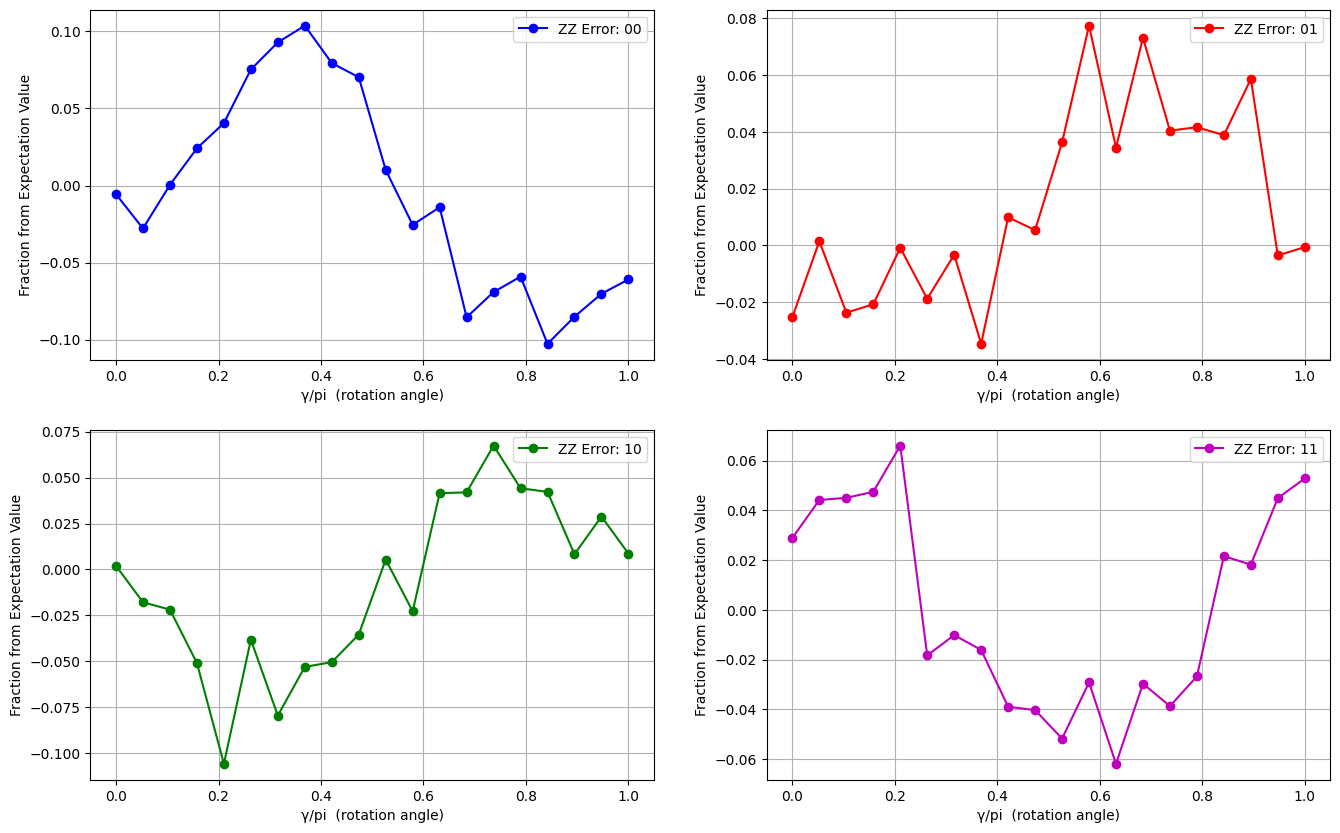

In [156]:
plot_results(results_dict, fname="plots/rzz_err_by_angle_hardware.png")

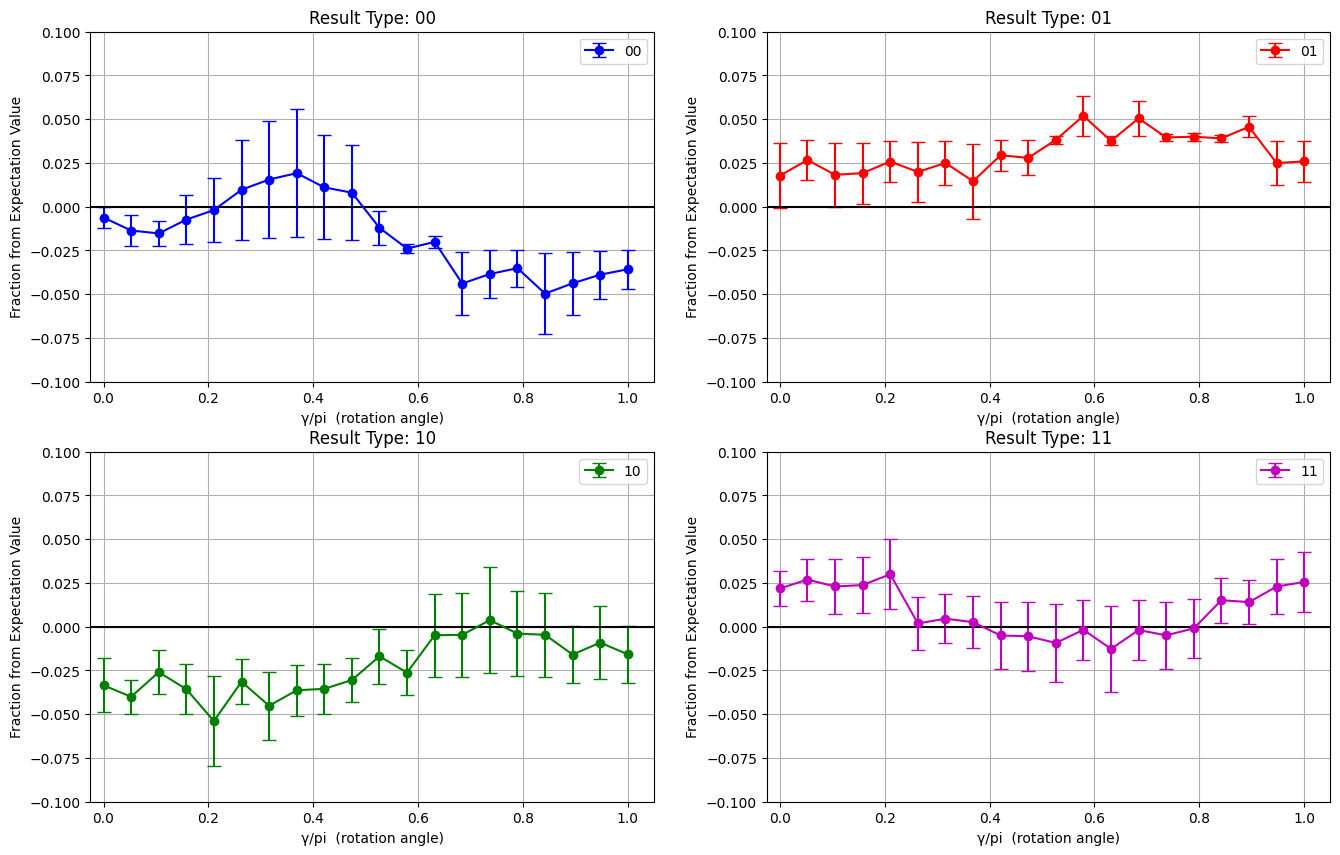

In [159]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_with_error_bars(df_all_results, fname):
    """
    Plots subplots for each result_type from the DataFrame df_all_results.
    Each subplot has gamma on the x-axis and the average value on the y-axis,
    with error bars representing the standard deviation over repeats.
    """
    # Reset the index to work with grouped data
    df_reset = df_all_results.reset_index()
    df_reset["value"] /= (shots/4)
    df_reset["value"] -= 1

    # Group by result_type and gamma, and calculate mean and standard deviation
    grouped = df_reset.groupby(["result_type", "gamma"]).agg(
        mean_value=("value", "mean"),
        std_value=("value", "std")
    ).reset_index()

    # Get unique result_types for subplots
    result_types = grouped["result_type"].unique()

    # Create subplots
    fig, axes = plt.subplots(2,2, 
                             figsize=(16, 10))

    # Ensure axes is iterable even if there's only one subplot
    if len(result_types) == 1:
        axes = [axes]
    clrs = ["b", "r", "g", "m"]
    ylims = [-0.1, 0.1]
    # Plot for each result_type
    for i, (ax, result_type) in enumerate(zip(axes.flatten(), result_types)):
        # Filter data for the current result_type
        data = grouped[grouped["result_type"] == result_type]

        # Plot with error bars
        ax.errorbar(
            data["gamma"], data["mean_value"], yerr=data["std_value"]/2,
            fmt='o-', capsize=5, label=result_type,
            color=clrs[i]
        )


        # Set labels and title
        ax.set_title(f"Result Type: {result_type}")
        ax.set_xlabel("Gamma")
        ax.set_ylabel("Average Value")
        ax.legend()
        ax.grid("on")
        ax.set_xlabel(r"γ/pi  (rotation angle)")
        ax.set_ylabel("Fraction from Expectation Value")
        ax.set_ylim(ylims)

        ax.plot([min(ax.get_xlim()), max(ax.get_xlim())], 
                [0, 0], color="k", linewidth=1.5)
        ax.set_xlim([-0.025, 1.05])


    # Adjust layout
    plt.savefig(fname, bbox_inches="tight")

# Call the function to plot
plot_results_with_error_bars(df_all_results, fname="plots/rzz_err_by_angle_hardware_3reps.png")

## Simulator

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import Parameter

# details to allow it to run later
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")

# Make the circuit
# Can initialise it all now and pass in a parameter 
def make_circuit(gamma):
    qc = QuantumCircuit(2)
    # gamma = Parameter("angle")
    # some hadamard gates first to ensure entanglement
    qc.h(0)
    qc.h(1)
    qc.rzz(2 * gamma, 0, 1)  # Virtual Rz(2γ)
    qc.measure_all()
    return qc

DataBin(meas=BitArray(<shape=(), num_shots=65536, num_bits=1>))

In [165]:
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
# pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)
from qiskit_ibm_runtime import Batch
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
backend = service.backend("ibm_brisbane")
pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Define rotation angles to test
gamma_values = np.pi*np.linspace(0, 1, 20)  # Test 50 angles between 0 and π

# some parameters
repeat_num = 3
shots = 2**16
poss_outcomes = ["00", "01", "10", "11"]
name_per_outc = ["gamma"] + [f"rep{rep_num}" for rep_num in range(repeat_num)]
results_dict = {outcome: {name : [] for name in name_per_outc} for outcome in poss_outcomes}
ids = []
count = 3
with Batch(backend=backend) as batch:
    for repeats in range(repeat_num):
        error_rates = []
        for gamma_val in gamma_values:
            # noise
            # qc.assign_parameters({gamma: gamma_val})
            qc = make_circuit(gamma=gamma_val)
            isa_qc = pm_noisy.run(qc)
            sampler = Sampler(mode=batch) #Sampler(mode=simulator)
            job = sampler.run([isa_qc], shots=shots)
            
            # some packing
            result_noise = job.result()
            count += 1
            err_per_outcome = []
            for outcome in poss_outcomes:
                outcome_num = result_noise[0].data.meas.get_counts().get(outcome, 0)
                outcome_diff = [abs(outcome_num - shots/4)]
                results_dict[outcome]["gamma"].append(gamma_val)
                results_dict[outcome][f"rep{repeats}"].append(outcome_diff)





c:\Users\rafew\OneDrive\Documents\qaoa_err_invest\.venv\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:830: UserWarning: The backend ibm_brisbane currently has a status of internal.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Plot results
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs_flat = axs.flatten()
clrs = ["b", "r", "g", "m"]
for i, outcome in enumerate(poss_outcomes):
    axs_flat[i].plot(np.array(results_dict[outcome]["gamma"])/np.pi,
            np.array(results_dict[outcome]["rep0"])/(shots/4),
            marker="o", linestyle="-", color=clrs[i], label=f"ZZ Error: {outcome}")
    # plt.figure(figsize=(8, 5))
    # plt.errorbar(gamma_values/np.pi, err_rate_means, yerr=np.array(err_rate_std)/2,
    #              )
    axs_flat[i].set_xlabel(r"γ/pi  (rotation angle)")
    axs_flat[i].set_ylabel("Error rate")
    # axs_flat[i].set_title("Error Rate of ZZ Mixer Gate on IBM Noise Model")
    axs_flat[i].legend()
    axs_flat[i].grid()
# ax.show()
plt.savefig("rzz_err_by_angle_simulator.png", bbox_inches="tight")